## EDA
### Contract, Billing & Pricing Analysis

In [1]:
## Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Load the cleaned data
df = pd.read_csv("../data/processed/cleaned_telco_customer_churn.csv")

print(df.shape)
df.head()

(7021, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 1. Which contract type has the highest churn?


In [18]:
## Contract type with churn rate
contract_wise_churn = df.groupby(by=['Contract']).agg({'Churn': [lambda x: ((x=='Yes').mean()*100).round(2), 'count']}).reset_index()
contract_wise_churn.columns = ['Contract', 'Churn_Rate', 'Customer_Count']
contract_wise_churn = contract_wise_churn.sort_values(by='Churn_Rate', ascending=False) 
contract_wise_churn

,Contract,Churn_Rate,Customer_Count
0,Month-to-month,42.68,3871
1,One year,11.32,1467
2,Two year,2.85,1683


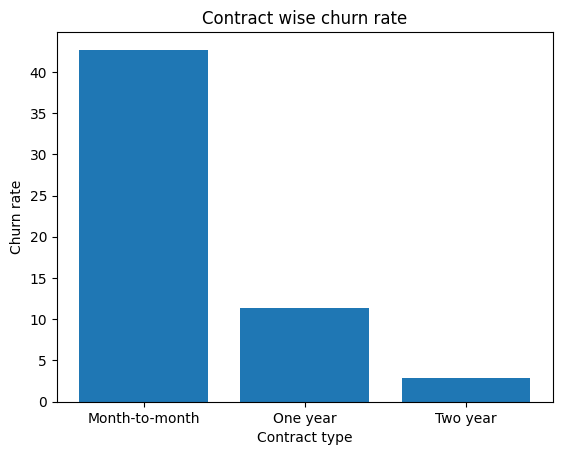

In [19]:
## Visualization
plt.figure()
plt.bar(x=contract_wise_churn['Contract'], height=contract_wise_churn['Churn_Rate'])
plt.title("Contract wise churn rate")
plt.xlabel("Contract type")
plt.ylabel("Churn rate")
plt.show()

#### Comment:
The above analysis reveals that customers with a **month-to-month** contract exhibit the highest churn rate at approximately **42.68%**, indicating a significant risk of attrition in this segment. 

In contrast, those with one-year and two-year contracts show substantially lower churn rates of 11.32% and 2.85%, respectively. This suggests that longer-term commitments are associated with greater customer retention, highlighting the importance of contract duration in customer loyalty strategies.

### 2. Does monthly billing increase churn compared to long-term contracts?
Yes, monthly billing is associated with a higher churn rate compared to long-term contracts.

### 3. How does churn vary by payment method?

In [29]:
## paymentMethod type with churn rate
paymentMethod_wise_churn = df.groupby(by=['PaymentMethod']).agg({'Churn': [lambda x: ((x=='Yes').mean()*100).round(2)]}).reset_index()
paymentMethod_wise_churn.columns = ['Payment_Method', 'Churn_Rate']
paymentMethod_wise_churn = paymentMethod_wise_churn.sort_values(by='Churn_Rate', ascending=True) 
paymentMethod_wise_churn

,Payment_Method,Churn_Rate
1,Credit card (automatic),15.24
0,Bank transfer (automatic),16.73
3,Mailed check,19.23
2,Electronic check,45.28


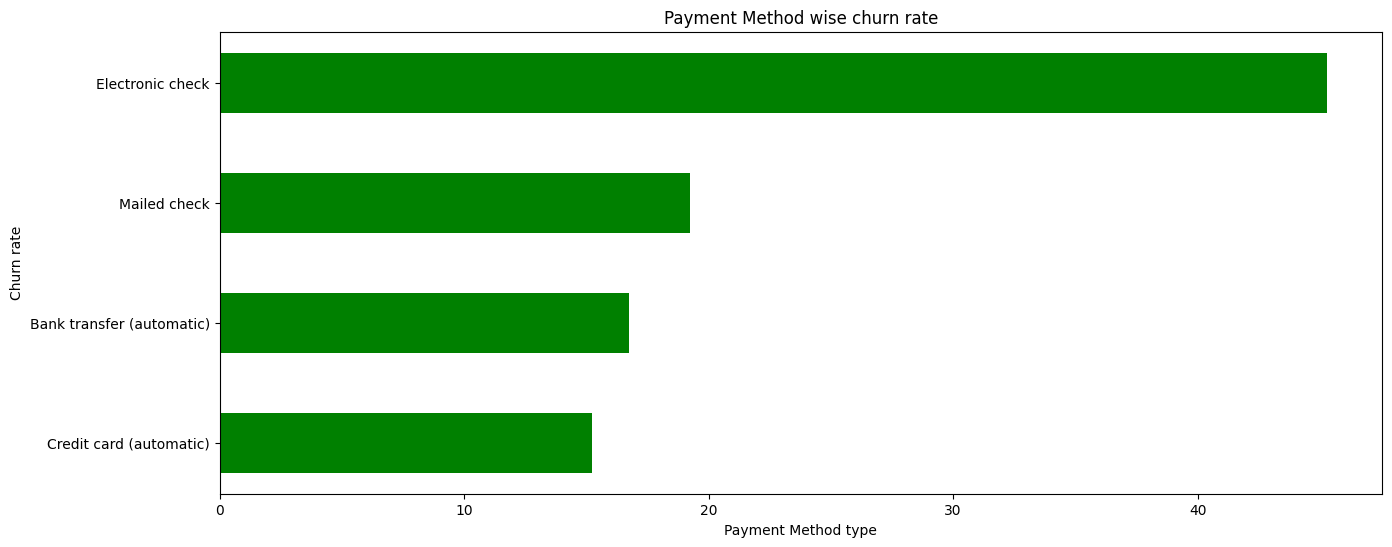

In [30]:
## Visualization
plt.figure(figsize=(15,6))
plt.barh(y=paymentMethod_wise_churn['Payment_Method'], width=paymentMethod_wise_churn['Churn_Rate'], height=0.5, color='g')
plt.title("Payment Method wise churn rate")
plt.xlabel("Payment Method type")
plt.ylabel("Churn rate")
plt.show()

#### Comment:
From this analysis, it is evident that customers who utilize **eloctronic checks** for their payments exhibit a significantly higher churn rate of approximately **45.28%**.  In contrast, customers using other payment methods such as mailed checks, bank transfers, and credit cards show considerably lower churn rates, ranging from about **15.24%** to **19.23%**. 

### 4. Do customers using electronic checks churn more?
Yes, customers using electronic checks have a higher churn rate.

### 5. Is higher monthly charge associated with higher churn?

In [71]:
## Calculate quantiles for MonthlyCharges
monthly_charge_churn = df[['MonthlyCharges', 'Churn']]
quantiles = df['MonthlyCharges'].quantile([i/100 for i in range(0,101, 5)]).values
quantiles

array([ 18.25,  19.65,  20.05,  20.6 ,  25.05,  35.55,  45.85,  53.15,
        58.85,  65.5 ,  70.35,  74.75,  79.1 ,  81.45,  85.5 ,  89.85,
        94.25,  98.5 , 102.6 , 107.4 , 118.75])

In [72]:
## Function to average bin values
def avg_bin(df, quantiles):
    for i in range(len(quantiles)-1):
        group_wise_mean = df[df.between(quantiles[i], quantiles[i+1])].agg('mean').round(4)
        df = df.apply(lambda x: group_wise_mean if (x >= quantiles[i]) & (x<= quantiles[i+1]) else x)
    return df

In [77]:
## Apply avg_bin function to MonthlyCharges
monthly_charge_churn.loc[:, 'MonthlyCharges'] = avg_bin(monthly_charge_churn['MonthlyCharges'], quantiles).values

monthly_charge_churn.head(10)

,MonthlyCharges,Churn
0,28.5984,No
1,55.4001,No
2,55.4001,Yes
3,42.7061,No
4,72.8279,Yes
5,100.2404,Yes
6,87.9322,No
7,28.5984,No
8,55.4001,No
9,49.7283,No


In [81]:
## Analyze churn rate based on binned MonthlyCharges
churn_trend_with_monthly_charge = monthly_charge_churn.groupby(by=['MonthlyCharges'])['Churn'].agg([lambda x: (x=='Yes').mean().round(2), 'count']).reset_index()
churn_trend_with_monthly_charge.columns = ['Monthly_Charges_Bin_Avg', 'Churn_Rate', 'Customer_Count']
churn_trend_with_monthly_charge

,Monthly_Charges_Bin_Avg,Churn_Rate,Customer_Count
0,19.3750,0.09,360
1,19.8867,0.08,354
2,20.3219,0.10,347
3,23.2825,0.10,354
4,28.5984,0.20,342
5,42.7061,0.31,350
6,49.7283,0.28,351
7,55.4001,0.21,351
8,61.9620,0.12,354
9,68.8202,0.32,352


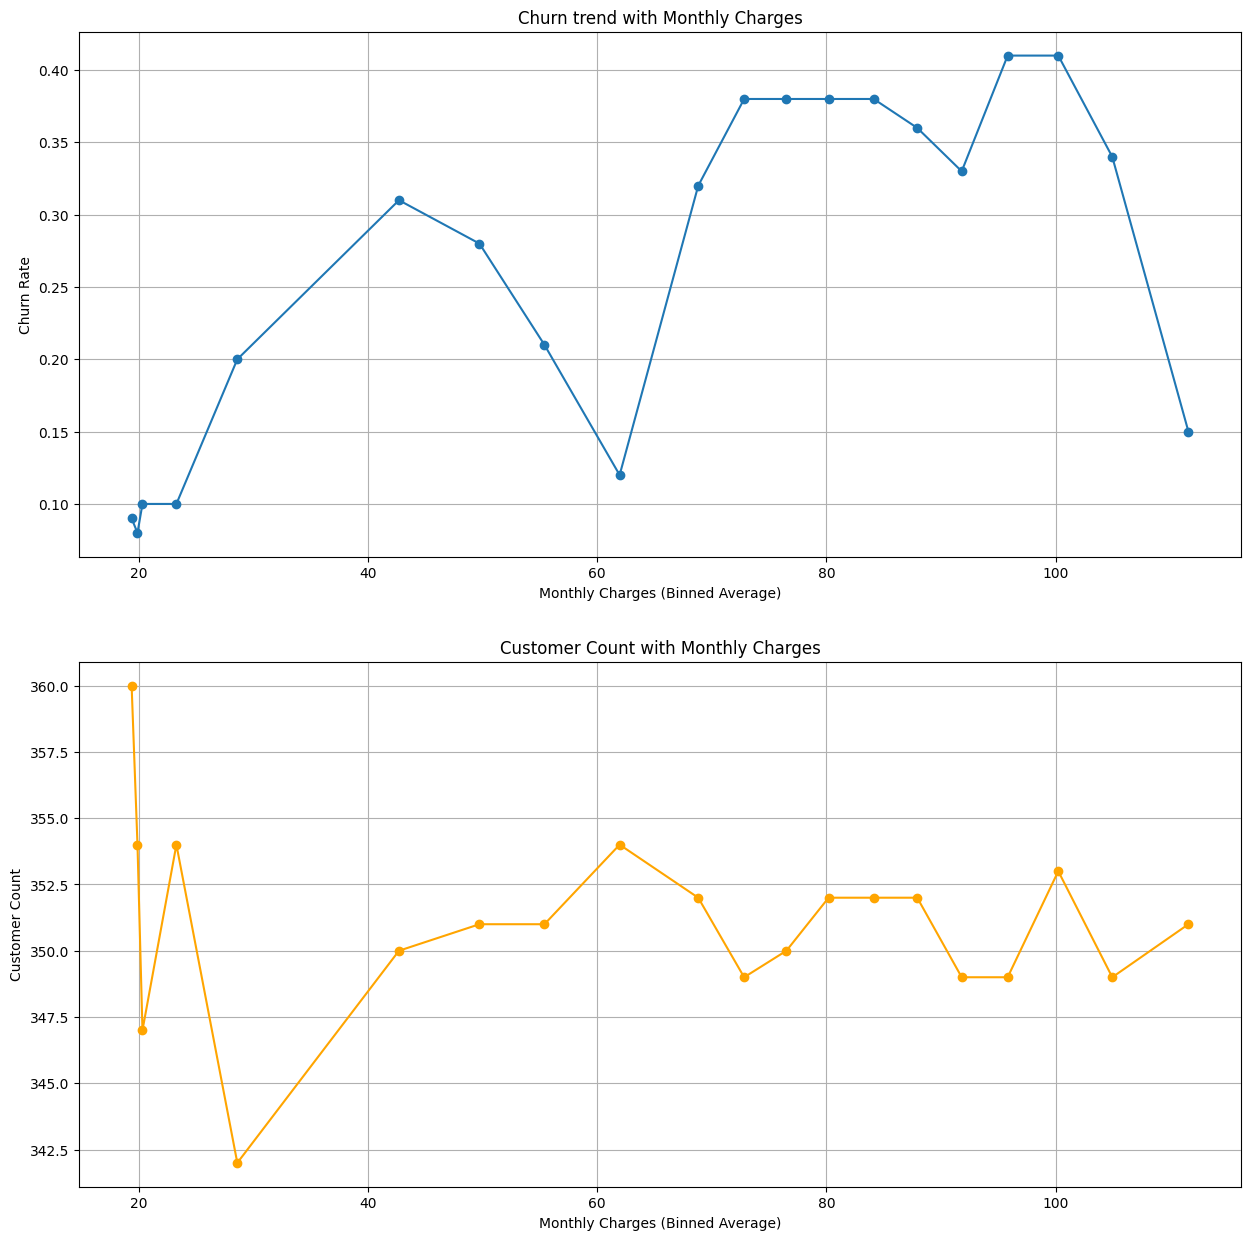

In [89]:
## Visualization of churn trend with MonthlyCharges
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.plot(churn_trend_with_monthly_charge['Monthly_Charges_Bin_Avg'], churn_trend_with_monthly_charge['Churn_Rate'], marker='o')
plt.title("Churn trend with Monthly Charges")
plt.xlabel("Monthly Charges (Binned Average)")
plt.ylabel("Churn Rate")
plt.grid()

plt.subplot(2,1,2)
plt.plot(churn_trend_with_monthly_charge['Monthly_Charges_Bin_Avg'], churn_trend_with_monthly_charge['Customer_Count'], marker='o', color='orange')
plt.title("Customer Count with Monthly Charges")
plt.xlabel("Monthly Charges (Binned Average)")
plt.ylabel("Customer Count")
plt.grid()
plt.show()

#### Comment:
* The analysis indicates a clear trend of churn rates with monthly charges. 
* Customers with lower monthly charges (around **$18.25 to $23.28**) exhibit a churn rate of approximately **10%** that is low.
* As monthly charges increase, the churn rate also rises, reaching up to **40%** for customers with monthly charges in the range of approximately **$89.55 to $100**.
* Again, churn rates around monthly charges **$110** is also less approximately **15%**. May be because of others factors.
* However, the no of customers in all groups remains same around 350 customers.

### 6. How does churn differ across billing paperless vs non-paperless customers?

In [92]:
paperlessBilling_wise_churn = df.groupby(by=['PaperlessBilling']).agg({'Churn': [lambda x: ((x=='Yes').mean()*100).round(2), 'count']}).reset_index()
paperlessBilling_wise_churn.columns = ['Paperless_Billing', 'Churn_Rate', 'Customer_Count']
paperlessBilling_wise_churn = paperlessBilling_wise_churn.sort_values(by='Churn_Rate', ascending=False)
paperlessBilling_wise_churn

,Paperless_Billing,Churn_Rate,Customer_Count
1,Yes,33.59,4159
0,No,16.39,2862


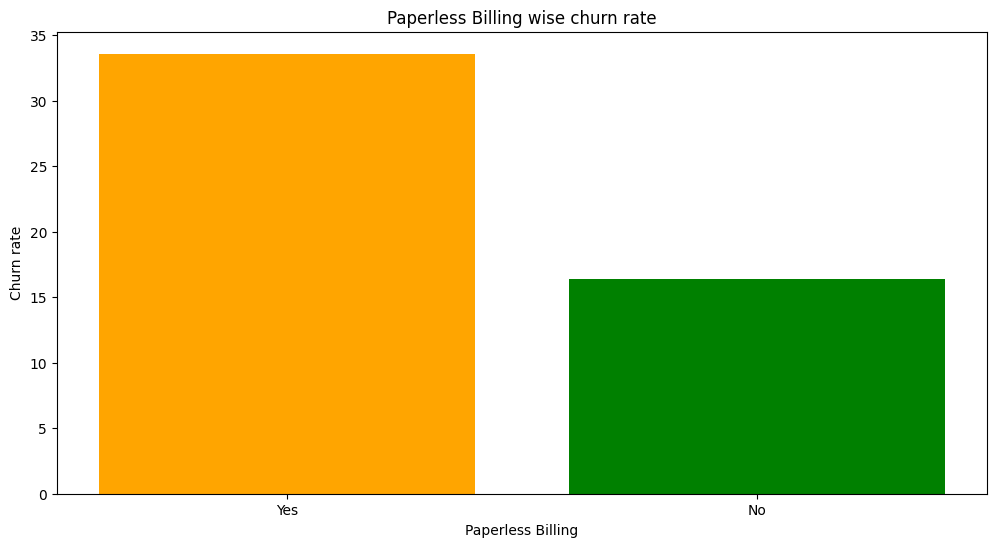

In [95]:
## Visualization
plt.figure(figsize=(12,6))
plt.bar(x=paperlessBilling_wise_churn['Paperless_Billing'], height=paperlessBilling_wise_churn['Churn_Rate'], color=['orange', 'green'])
plt.title("Paperless Billing wise churn rate")
plt.xlabel("Paperless Billing")
plt.ylabel("Churn rate")
plt.show()

#### Comment:
This analysis reveals that customers who opt for **paperless billing** exhibit a significantly higher churn rate of approximately **33.59%** compared to those who do not use paperless billing, who have a churn rate of about **16.39%**.

Though no of customers using paperless billing is higher (about 4159) compared to non-paperless which is 2862. This suggests that while paperless billing may offer convenience, it is also associated with a greater likelihood of customer attrition.

---
### 👨‍💻 Author Information
**Name:** [Amaresh Maity]  
**Date:** 2026-01-07  
**Role:** [Data Scientist | AI Engineer]



#### Let's Connect!

If you have questions about this analysis or would like to collaborate, feel free to reach out:

* **LinkedIn:** [LinkedIn](https://www.linkedin.com/in/amareshmaity/)
* **GitHub:** [@amareshmaity](https://github.com/amareshmaity)
* **Email:** [contacttoamaresh@gmail.com](mailto:contacttoamaresh@gmail.com)